In [2]:
import numpy as np
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import statsmodels.api as sm
from scipy import stats

In [188]:
pd.set_option('display.precision',2)
plt.style.use('default')

## Сложность используемого датасета ##

Датасет представляет собой данные о поездках пользователей Divvy Bikes - сервиса велошеринга в Чикаго.

Данные о поездках находятся в открытом доступе: https://www.divvybikes.com/system-data, оттуда они и были получены.

Каждой записи исходной таблицы соответствует информация об отдельном акте аренды велосипеда.

Поездки совершаются между станциями велопроката, установленными по городу.



## Первичный анализ данных ##

<b>Как были собраны данные</b>

Каждая станция проката оборудована датчиками, данные с которых логгируются на сервере компании. <br>
Велосипеды скорее всего имеют трекеры/таймеры и так далее. <br>
<br>

<b>Характеристика датасета</b>

Датасет представляет собой несколько csv файлов, каждый хранит данные за определенный квартал года или за месяц

id поездки и id велосипеда представлены целыми числами.<br>
Информация о начале и конце поездки представлены временными метками, записанными в строки.<br>
Отдельная колонка - длительность поездки в секундах. Хранится как строка в одной таблице и как число в других <br>
Указаны также id станций отбытия и прибытия целые числа.<br>
Названия соответствующих станций - строки.

Из информации о пользователе проката: <br>
    Тип пользователя: Customer, Subscriber. Первые катались по разовому суточному доступу, вторые по долгосрочному. Строка.<br>
    Пол пользователя - строка.<br>
    Год рождения - число float.<br>
<br>



## Предобработка данных ##

In [ ]:
# 2016

data1 = pd.read_csv('Divvy_Trips_2016_Q1.csv')
data2_4 = pd.read_csv('Divvy_Trips_2016_04.csv')
data2_5 = pd.read_csv('Divvy_Trips_2016_05.csv')
data2_6 = pd.read_csv('Divvy_Trips_2016_06.csv')
data3 = pd.read_csv('Divvy_Trips_2016_Q3.csv')
data4 = pd.read_csv('Divvy_Trips_2016_Q4.csv')

data2016 = pd.concat([data1, data2_4, data2_5, data2_6, data3, data4], ignore_index=True, copy=False)

data2016.rename(columns={'starttime':'start_time', "stoptime": "end_time"}, inplace = True)

repl = lambda s: s.group() + ':00' 
data2016.start_time = data2016.start_time.str.replace(r'\s\d{1,2}:\d\d$', repl)
data2016['time'] = pd.to_datetime(data2016.start_time, format= '%m/%d/%Y %H:%M:%S')

with open('2016_.csv', mode='w', encoding='utf-8') as f_csv:
    data2016.to_csv(f_csv, index=False)

In [ ]:
# 2017

data1 = pd.read_csv('Divvy_Trips_2017_Q1.csv')
data2 = pd.read_csv('Divvy_Trips_2017_Q2.csv')
data3 = pd.read_csv('Divvy_Trips_2017_Q3.csv')
data4 = pd.read_csv('Divvy_Trips_2017_Q4.csv')

data2017 = pd.concat([data1, data2, data3, data4], ignore_index=True, copy=False)

repl = lambda s: s.group() + ':00' 
data2017.start_time = data2017.start_time.str.replace(r'\s\d{1,2}:\d\d$', repl)
data2017['time'] = pd.to_datetime(data2017.start_time, format= '%m/%d/%Y %H:%M:%S')

with open('2017.csv', mode='w', encoding='utf-8') as f_csv:
    data2017.to_csv(f_csv, index=False)

In [ ]:
# 2018

data1 = pd.read_csv('Divvy_Trips_2018_Q1.csv')
data2 = pd.read_csv('Divvy_Trips_2018_Q2.csv')
data3 = pd.read_csv('Divvy_Trips_2018_Q3.csv')
data4 = pd.read_csv('Divvy_Trips_2018_Q4.csv')

# здесь колонки названы по разному
data1.columns = data2.columns

data2018 = pd.concat([data1, data2, data3, data4], ignore_index=True, copy=False)

# Хранится в текстовом формате с запятыми и точками 
data2018.tripduration = data2018.tripduration.str.slice(stop=-2).str.replace(',', '').astype('int64') 

data2018['time'] = pd.to_datetime(data2018.start_time, format= '%Y/%m/%d %H:%M:%S')

with open('2018.csv', mode='w', encoding='utf-8') as f_csv:
    data2018.to_csv(f_csv, index=False)

In [ ]:
# 2019

data1 = pd.read_csv('Divvy_Trips_2019_Q1.csv')
data2 = pd.read_csv('Divvy_Trips_2019_Q2.csv')
data3 = pd.read_csv('Divvy_Trips_2019_Q3.csv')

data2.columns = data1.columns

data2019 = pd.concat([data1, data2, data3], ignore_index=True, copy=False)

data2019.tripduration = data2019.tripduration.str.slice(stop=-2).str.replace(',', '').astype('int64') 

data2019['time'] = pd.to_datetime(data2019.start_time, format= '%Y/%m/%d %H:%M:%S')

with open('2019.csv', mode='w', encoding='utf-8') as f_csv:
    data2019.to_csv(f_csv, index=False)

In [3]:
data2016 = pd.read_csv('2016_.csv')
data2017 = pd.read_csv('2017_.csv')
data2018 = pd.read_csv('2018_.csv')
data2019 = pd.read_csv('2019_.csv')

In [6]:
df = pd.concat([data2016, data2017, data2018, data2019], ignore_index=True, copy=False)

In [17]:
df.drop_duplicates(subset='trip_id', inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10649557 entries, 0 to 10649556
Data columns (total 12 columns):
trip_id              int64
start_time           object
end_time             object
bikeid               int64
tripduration         int64
from_station_id      int64
from_station_name    object
to_station_id        int64
to_station_name      object
usertype             object
gender               object
birthyear            float64
dtypes: float64(1), int64(5), object(6)
memory usage: 975.0+ MB


In [8]:
df.drop(columns = ['usertype', 'start_time', 'end_time', 'trip_id', 'bikeid', 'from_station_id', 'from_station_name', 'to_station_id', 'to_station_name'], inplace=True)

In [19]:
df.dropna(subset=['gender', 'birthyear'], inplace=True)

# df.usertype = df.usertype.astype('category') 
df.gender = df.gender.astype('category')
df.birthyear = df.birthyear.astype('int')

In [20]:
df.index = pd.to_datetime(df.time, format='%Y/%m/%d %H:%M:%S')

In [21]:
df.drop(columns=['time'], inplace = True)

In [22]:
df['year'] = df.index.year.values
df['month'] = df.index.month.values
df['hour'] = df.index.hour.values
df['week_day'] = df.index.weekday.values + 1

In [23]:
df['age'] = df.year - df.birthyear

df.drop(columns=['birthyear'], inplace=True)

In [24]:
# Будем измерять длительность поездки в минутах
df.tripduration /=60

<br>
В датасете имеются аномалии в виде аренд длительностью в тысячи минут.

In [25]:
df.sort_values('tripduration', ascending=False).head(5)

,trip_id,start_time,end_time,bikeid,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,usertype,gender,year,month,hour,week_day,age
time,,,,,,,,,,,,,,,,
2018-01-25 19:56:04,17634739,2018-01-25 19:56:04,2018-07-01 18:56:21,5956,225960.00,585,Cottage Grove Ave & 83rd St,392,Perry Ave & 69th St,Subscriber,Male,2018,1,19,4,21
2018-08-09 20:30:22,20052755,2018-08-09 20:30:22,2018-12-20 13:21:33,771,191151.67,417,Cornell Ave & Hyde Park Blvd,417,Cornell Ave & Hyde Park Blvd,Subscriber,Female,2018,8,20,4,66
2018-09-13 08:41:37,20673996,2018-09-13 08:41:37,2019-01-06 14:40:28,1792,166018.83,192,Canal St & Adams St,452,Western Ave & Granville Ave,Subscriber,Male,2018,9,8,4,49
2019-07-16 18:17:58,23798837,2019-07-16 18:17:58,2019-10-29 14:01:52,1229,150943.88,418,Ellis Ave & 53rd St,671,HUBBARD ST BIKE CHECKING (LBS-WH-TEST),Subscriber,Male,2019,7,18,2,20
2018-08-14 16:55:56,20153273,2018-08-14 16:55:56,2018-11-23 16:46:31,5961,145490.67,388,Halsted St & 63rd St,539,Cicero Ave & Quincy St,Subscriber,Male,2018,8,16,2,25


 Возможно, это случаи с забытыми велосипедами или несработавшими датчиками при закреплении велосипеда на станции  и т.д.

Так или иначе, такие аренды считать поездками мы не будем

99 процентов всех поездок длились меньше ~57 минут:

In [26]:
np.percentile(df.tripduration, 99)

57.18333333333333

Для удобства работы с данными ограничимся арендой 60 минут. 

Этого более, чем достаточно.

In [ ]:
df = df[df.tripduration < 60]

In [8]:
# Save assembled data to file:

# with open('ALL.csv', mode='w', encoding='utf-8') as f_csv:
#     df.to_csv(f_csv)

In [5]:
# Read assembled data from file:

df = pd.read_csv('ALL.csv')

df.index = pd.to_datetime(df.time, format='%Y/%m/%d %H:%M:%S')

df.drop(columns='time', inplace=True)

df.sort_index(inplace=True)

In [6]:
df.head()

,tripduration,gender,year,month,hour,week_day,age
time,,,,,,,
2016-01-01 00:07:00,8.47,Male,2016,1,0,5,51
2016-01-01 00:14:00,10.25,Female,2016,1,0,5,35
2016-01-01 00:15:00,12.40,Male,2016,1,0,5,22
2016-01-01 00:16:00,8.07,Female,2016,1,0,5,40
2016-01-01 00:16:00,8.53,Male,2016,1,0,5,34


## Визуальный анализ данных ##

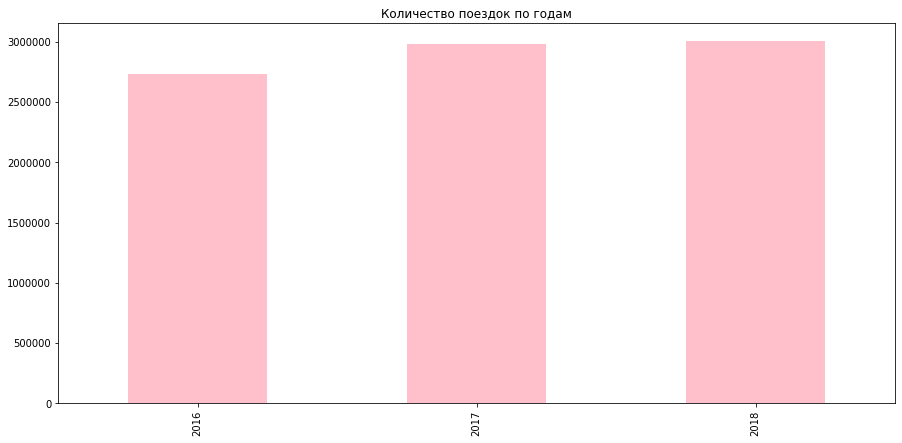

In [16]:
plt.figure(figsize=(15, 7))
# Исключим неполный 2019 год из данных для визуализации
df[df.year!=2019].year.value_counts(sort=False).plot.bar(color='pink')
plt.title('Количество поездок по годам')
plt.show()

1) Количество поездок по месяцам

Ближе к лету становится больше поездок. 

Судя по гистограмме, велосезон - с мая по октбярь.

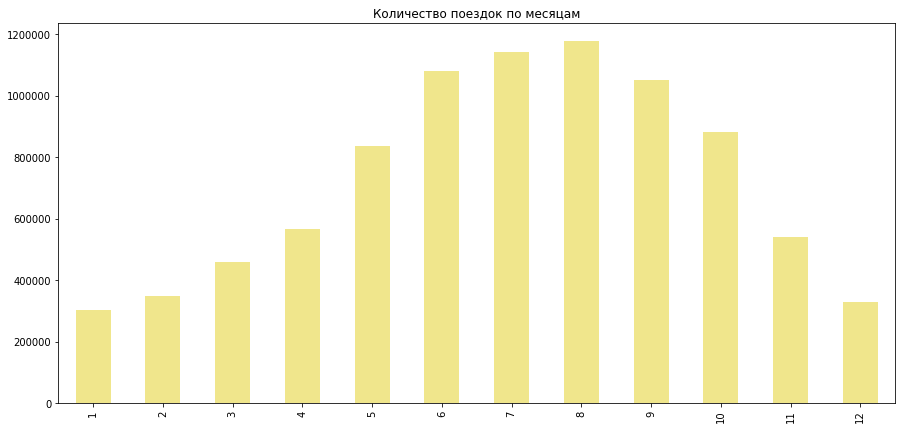

In [17]:
plt.figure(figsize=(15, 7))
# Исключим неполный 2019 год из данных для визуализации
df[df.year != 2019].month.value_counts(sort=False).plot.bar(color='khaki')
plt.title('Количество поездок по месяцам')
plt.show()

2) Количество поездок по дням недели

Судя по гистограмме, какая-то часть клиентов сервиса используют эти велосипеды для поездки на работу/учёбу.

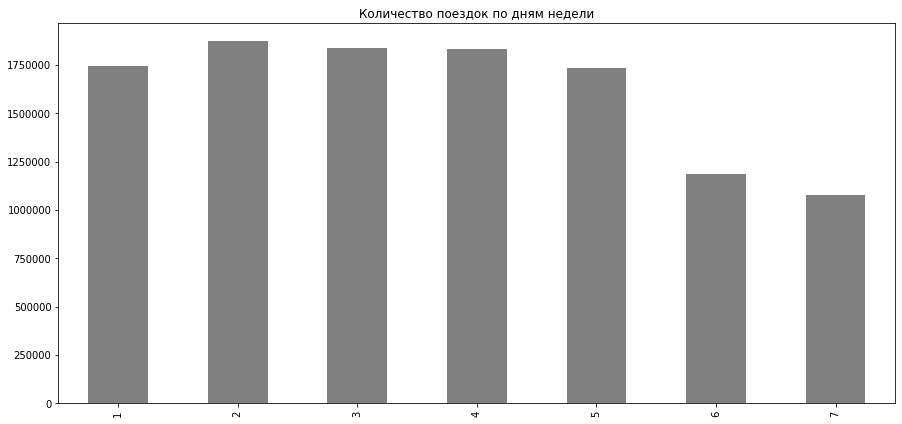

In [18]:
plt.figure(figsize=(15, 7))
df.week_day.value_counts(sort=False).plot.bar(color='gray')
plt.title('Количество поездок по дням недели')
plt.show()

3) Количество поездок по времени дня

Два пика поездок приходятся на время, в которое обычно люди едут на работу / с работы

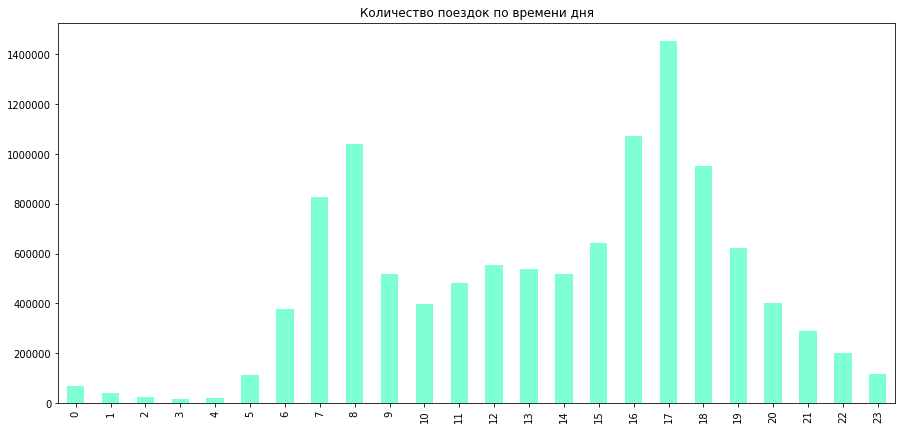

In [19]:
plt.figure(figsize=(15, 7))
df.hour.value_counts(sort=False).plot.bar(color='aquamarine')
plt.title('Количество поездок по времени дня')
plt.show()

А как обстоят дела в выходные?

В выходные люди катаются в основном днём:

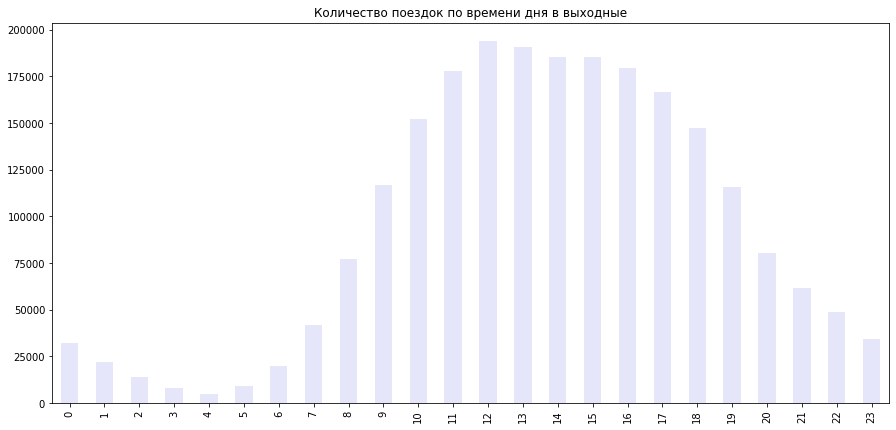

In [20]:
plt.figure(figsize=(15, 7))
df[df.week_day > 5].hour.value_counts(sort=False).plot.bar(color='lavender')
plt.title('Количество поездок по времени дня в выходные')
plt.show()


Но в будни в это время дня всё равно значительно больше поездок.

4) Количество поездок в зависимости от возраста и от пола.

Среди тех, кто предоставил данные о возрасте и поле наблюдается следующая картина:

Верхний график соответствует мужчинам, нижний - женщинам.

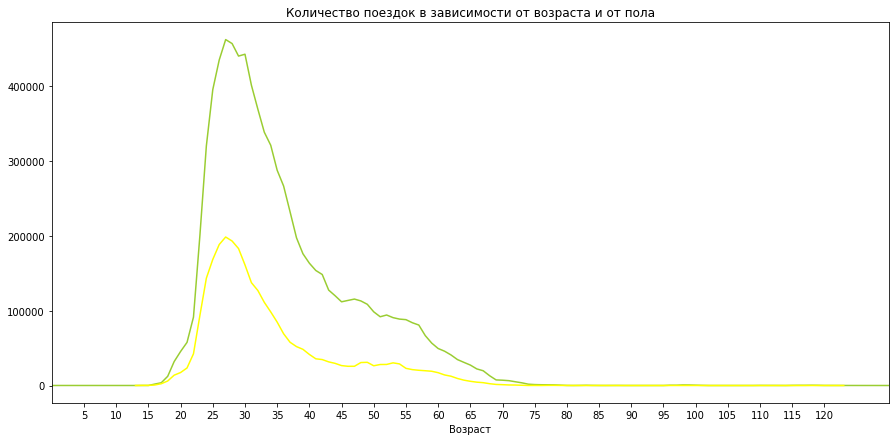

In [21]:
plt.figure(figsize=(15, 7))
df[df.gender=='Male'].age.value_counts(sort=False).plot.line(color='yellowgreen')
df[df.gender=='Female'].age.value_counts(sort=False).plot.line(color='yellow')
plt.xticks(ticks=list(range(5,125,5)))
plt.xlabel('Возраст')
plt.title('Количество поездок в зависимости от возраста и от пола')
plt.show()

5) Распределение длительности поездок.

Похоже на логнормальное распределение

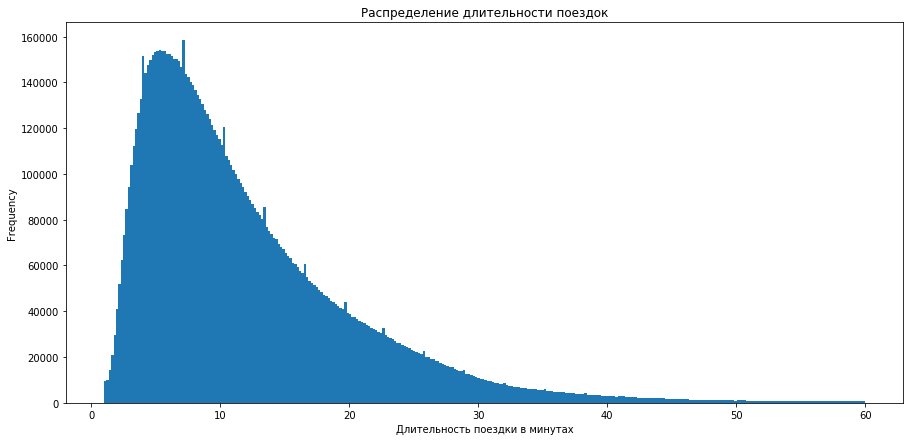

In [22]:
plt.figure(figsize=(15, 7))
df.tripduration.plot.hist(bins=320)
plt.title('Распределение длительности поездок')
plt.xlabel('Длительность поездки в минутах')
plt.show()

6) Медианная продолжительность поездки у женщин немного больше, чем у мужчин.

Возможно это связано с тем, что они катаются медленнее.

Сравнение квартилей и порога статистически значимой выборки также может указывать на это.

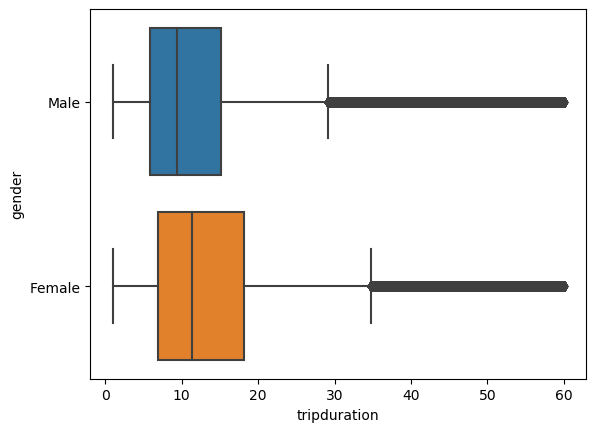

In [23]:
plt.style.use('default')
sns.boxplot(y="gender", x="tripduration", data=df, orient="h")
plt.show()

7) Наибольшим спросом велопрокат пользуется у людей 25-35 лет: 

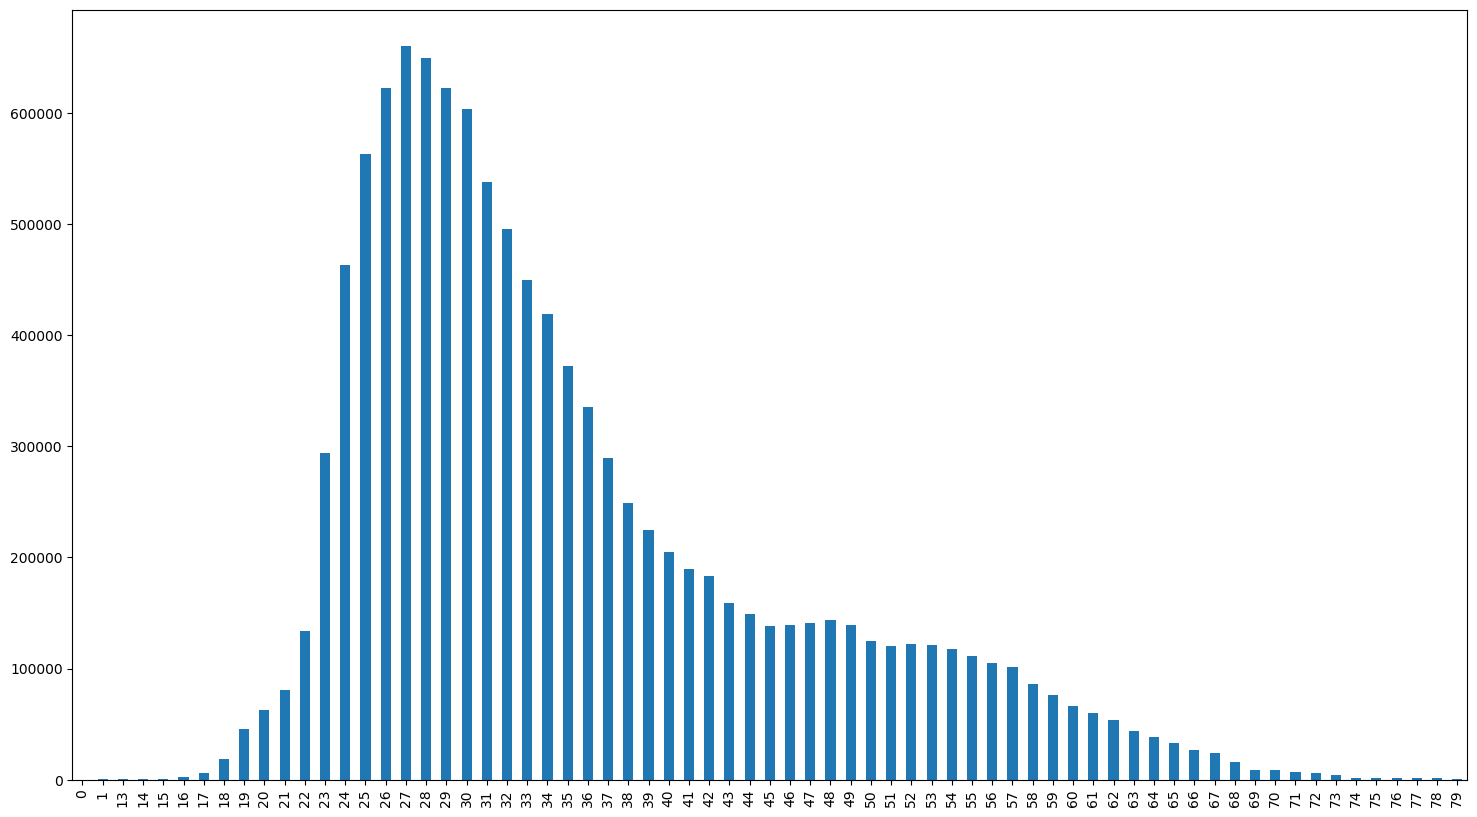

In [251]:
plt.figure(figsize=(18, 10))
df[df.age<80].age.value_counts(sort=False).plot.bar()
plt.show()

8) Ещё оказывается, что в велосезон люди катаются дольше:

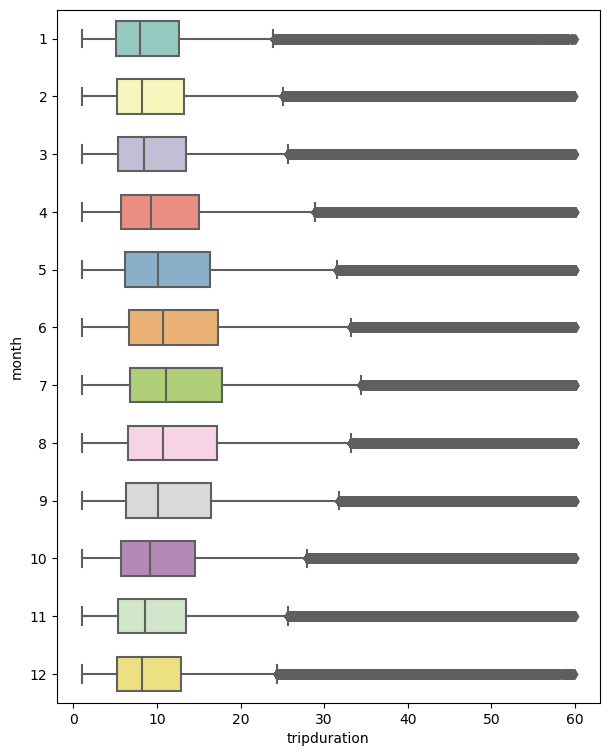

In [258]:
# plt.rc('figure', figsize=(7, 9))
sns.boxplot(y="month", x="tripduration", palette="Set3", width=0.6, data=df, orient="h")
plt.show()

9) В будни поездки короче, чем в выходные

Видимо в выходные люди чуть меньше торопятся

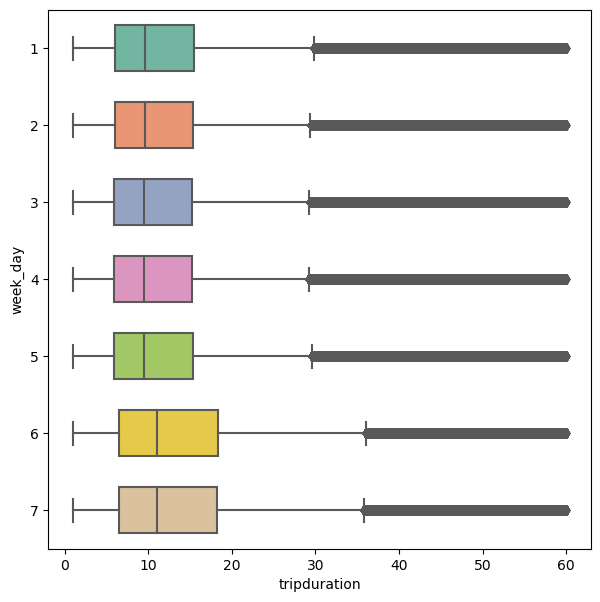

In [281]:
plt.rc('figure', figsize=(7, 7))
sns.boxplot(y="week_day", x="tripduration", palette="Set2", width=0.6, data=df, orient="h")
plt.show()

# Временной ряд #

Построим из датасета временной ряд и исследуем его. 

Измерения у нас будут ежечасные, для этого усредним/подсчитаем значения за каждый час.

Будем работать с двумя значениями: средняя длительность поездок, совершенных за час и количество поездок за час.

In [138]:
t = df.drop(columns=['year', 'month', 'hour', 'week_day', 'gender'])

In [139]:
# hour timestamps
time_rounding = 'H'

time_base = pd.date_range(start = df.index[0].normalize(), end =df.index[-1].normalize(), freq = time_rounding) 

In [140]:
t.index = t.index.round(time_rounding)

In [141]:
ride_counts = t.groupby('time').count()[['age']]
ride_counts.rename(columns={'age':'rides'}, inplace=True)

In [142]:
t = t.groupby('time')['tripduration', 'age'].mean()

In [143]:
t = pd.concat([t, ride_counts], axis=1)

t = t.reindex(index=time_base, fill_value = 0)

In [144]:
series = t

<h3> 1. Анализ временного ряда

Рассматриваем ряд с информацией о средней длительности поездок за каждый час

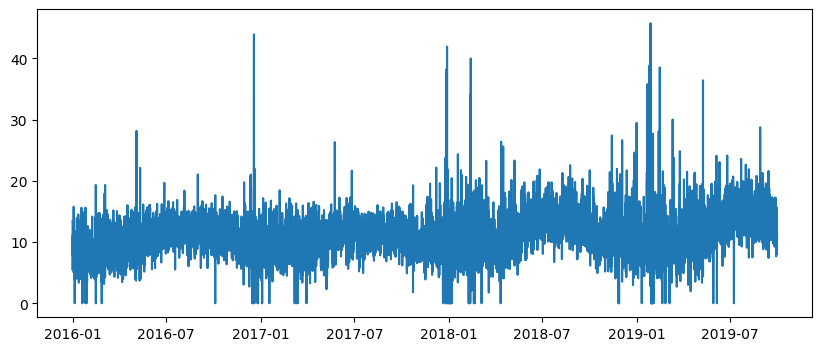

In [276]:
plt.figure(figsize=(10, 4))
plt.plot(t.index, t.tripduration, color='tab:blue')
plt.show()

<b>Тренд

In [212]:
t = t[['tripduration']]

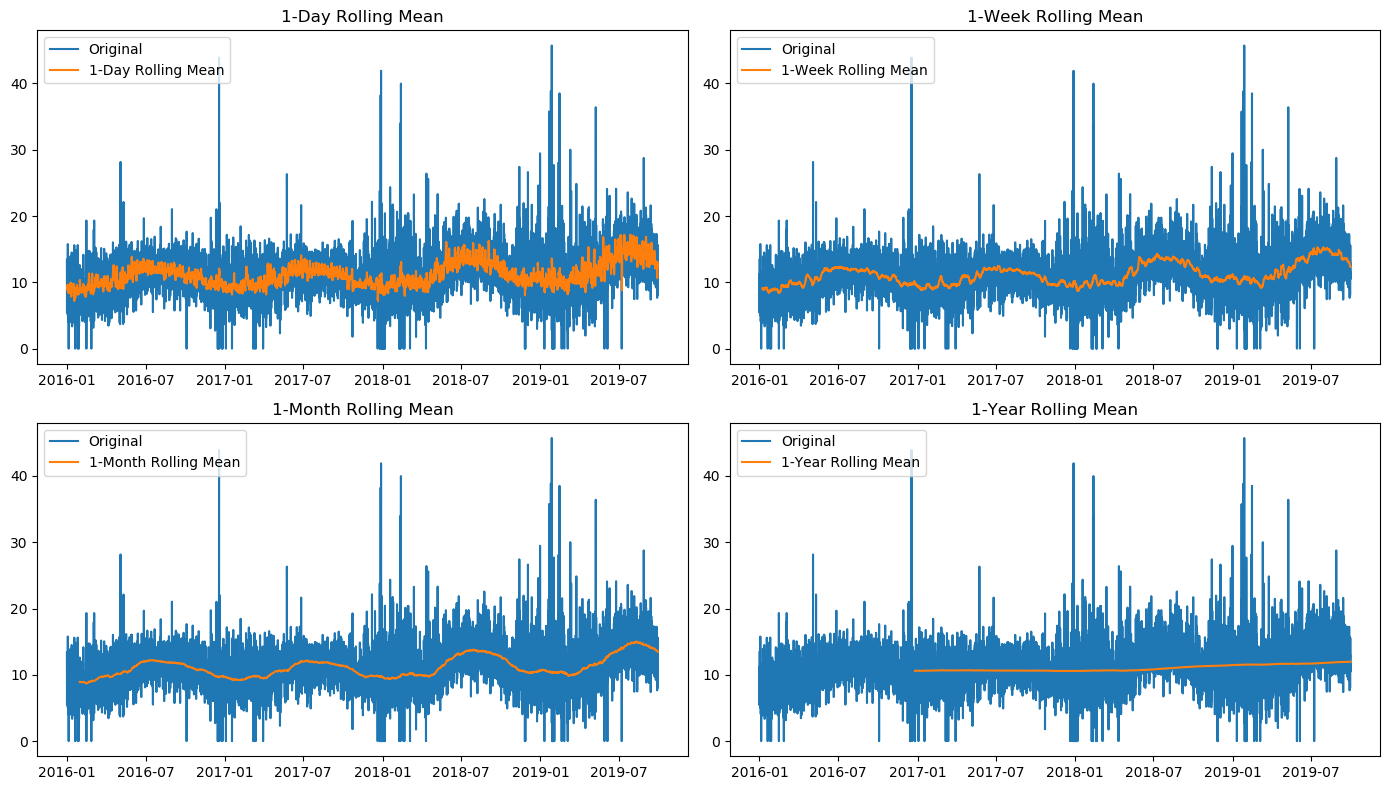

In [213]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(14)
fig.set_figheight(8)

window =  24
axes[0][0].plot(t.index, t, label='Original')
axes[0][0].plot(t.index, t.rolling(window=window).mean(), label='1-Day Rolling Mean')
axes[0][0].set_title("1-Day Rolling Mean")
axes[0][0].legend(loc='best')

window = 24*7
axes[0][1].plot(t.index, t, label='Original')
axes[0][1].plot(t.index, t.rolling(window=window).mean(), label='1-Week Rolling Mean')
axes[0][1].set_title("1-Week Rolling Mean")
axes[0][1].legend(loc='best')

window = 24*30
axes[1][0].plot(t.index, t, label='Original')
axes[1][0].plot(t.index, t.rolling(window=window).mean(), label='1-Month Rolling Mean')
axes[1][0].set_title("1-Month Rolling Mean")
axes[1][0].legend(loc='best')

window = 24*30*12
axes[1][1].plot(t.index, t, label='Original')
axes[1][1].plot(t.index, t.rolling(window=window).mean(), label='1-Year Rolling Mean')
axes[1][1].set_title("1-Year Rolling Mean")
axes[1][1].legend(loc='best')

plt.tight_layout()
plt.show()

<b>Сезонность </b>
    
Очевидно, годовая

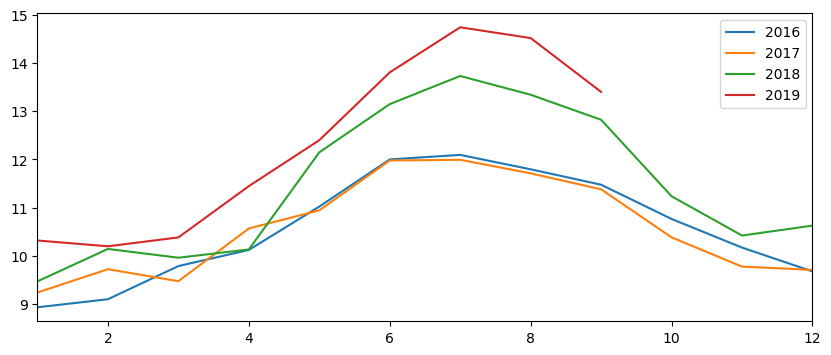

In [233]:
t_pivot = pd.pivot_table(t, values = 'tripduration', columns = t.index.year, index=t.index.month)

t_pivot.plot(figsize=(10,4))
plt.show()

<b>Итог

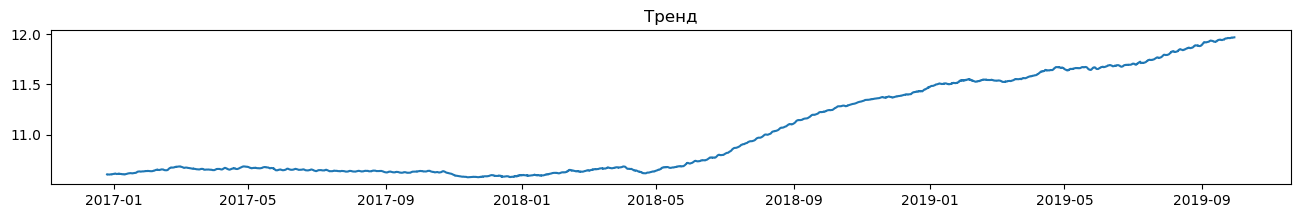

In [245]:
plt.figure(figsize=(16,2))
plt.title('Тренд')
plt.plot(t.index, t.rolling(window=24*30*12).mean())
plt.show()


Оказывается, с весны 2018-го среднее время проката постоянно увеличивается. 

Целых две минуты за полтора года!

Медленно, но верно :)

<h3>2. Предсказание по временному ряду

In [ ]:
Рассматриваем ряд с информацией о количестве поездок за каждый час